In [1]:
import random
from dataclasses import dataclass
from functools import cache

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import trange

In [2]:
np.random.seed(42)
random.seed(42)

# Подзадача 1

In [3]:
ACTION_TAKE_MORE = 'hit'
ACTION_STOP_TAKING = 'stick'
COLOR_BLACK = 'black'
COLOR_RED = 'red'


@dataclass
class Card:
    number: int
    color: str


def get_new_card():
    number = random.randint(1, 10)

    color = np.random.choice(
        [COLOR_RED, COLOR_BLACK],
        1,
        p=[1/3, 2/3]
    )[0]

    return Card(number, color)

def apply_new_card_to_state(s, card, player):
    taker_sum, player_sum = s
    delta = card.number * \
                (-1 if card.color == COLOR_RED else 1)
    if player:
        return taker_sum, player_sum + delta
    else:
        return taker_sum + delta, player_sum

def calc_reward_on_take_more(s):
    _, player_sum = s

    if player_sum < 0 or player_sum > 21:
        return -1
    else:
        return 0


def take_cards_as_taker(s):
    taker_sum, player_sum = s
    while 0 <= taker_sum < 17:
        new_card = get_new_card()
        taker_sum, _ = apply_new_card_to_state(
            (taker_sum, player_sum),
            new_card,
            False
        )
    return taker_sum, player_sum


def calc_reward_on_stop_taking(s):
    taker_sum, player_sum = s
    if taker_sum < 0 or taker_sum > 21 or taker_sum < player_sum:
        return 1
    elif taker_sum == player_sum:
        return 0
    else:
        return -1


def is_terminal(s):
    taker_sum, player_sum = s
    return taker_sum < 0 \
        or player_sum < 0 \
        or player_sum > 21 \
        or taker_sum >= 17


def environment_step(s, a):
    if a == ACTION_TAKE_MORE:
        new_card = get_new_card()
        new_s = apply_new_card_to_state(s, new_card, True)
        reward = calc_reward_on_take_more(new_s)
        return new_s, reward
    elif a == ACTION_STOP_TAKING:
        new_s = take_cards_as_taker(s)
        reward = calc_reward_on_stop_taking(new_s)
        return new_s, reward

s1, r = environment_step((1, 18), ACTION_TAKE_MORE)
s1, r, is_terminal(s1)

((1, 20), 0, False)

# Подзадача 2

In [4]:
def get_start_state():
    taker_card, player_card = get_new_card(), get_new_card()
    return taker_card.number, player_card.number

def epsilon_greedy_with_eps_calc(best_action, n, n0, s):
    e = n0 / (n0 + np.sum(n[s]))
    if np.random.random(1)[0] <= e:
        a = random.choice([0, 1])
    else:
        a = best_action
    return a

def glie_mc_estimate(episodes, n0, gamma=1):
    policy = np.zeros((11, 22), dtype=int)
    q = np.zeros((11, 22, 2))
    n = np.zeros((11, 22, 2))

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }

    for _ in trange(episodes):
        episode = list()
        episode_without_rewards = list()

        s = get_start_state()

        while not is_terminal(s):
            # e = n0 / (n0 + np.sum(n[s]))
            # if np.random.random(1)[0] <= e:
            #     a = random.choice([0, 1])
            # else:
            #     a = policy[s]
            a = epsilon_greedy_with_eps_calc(policy[s], n, n0, s)
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )
            episode.append((s, a, r))
            episode_without_rewards.append((s, a))
            s = s1
        # print(episode)
        g = 0
        for i in range(len(episode) - 1, -1, -1):
            s, a, r = episode[i]
            g = gamma * g + r

            if episode_without_rewards.index((s, a)) != i:
                continue

            q_index = s[0], s[1], a
            n[q_index] += 1
            q[q_index] += 1 / n[q_index] * (g - q[q_index])
            a_star = np.argmax(q[s])
            policy[s] = a_star

    return policy, q

policy_mc, q_mc = glie_mc_estimate(10000, 100);

100%|██████████| 10000/10000 [00:01<00:00, 7792.28it/s]


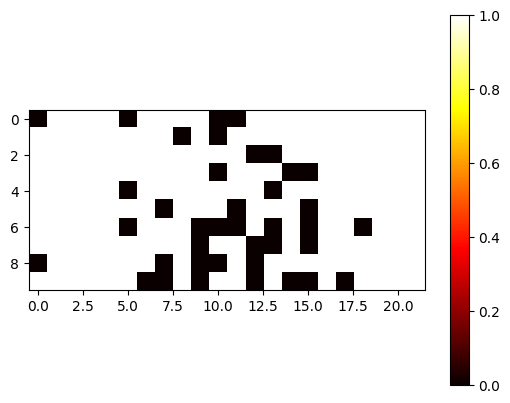

In [5]:
plt.imshow(policy_mc[1:, :], cmap='hot')
plt.colorbar();

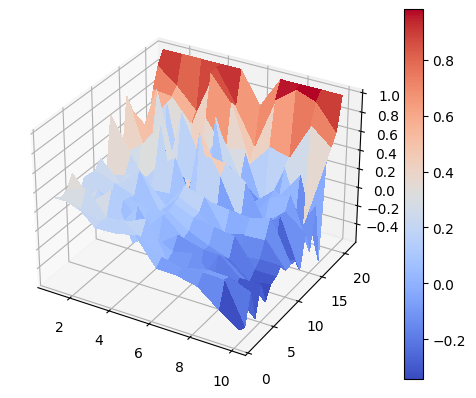

In [6]:
def plot_q(q):
    X = np.arange(1, 11, 1)
    Y = np.arange(1, 22, 1)
    X, Y = np.meshgrid(X, Y)
    Z = np.max(q, axis=2)[X, Y]

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)

plot_q(q_mc)

# Подзадача 3

In [7]:
def sarsa_estimate(episodes, n0, lambda_coef, gamma, mse_collect=False, q_mc=None):
    q = np.zeros((11, 22, 2))
    n = np.zeros_like(q)

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }
    mse_vals = list()

    for _ in trange(episodes):
        e = np.zeros_like(q)
        s = get_start_state()
        a = epsilon_greedy_with_eps_calc(np.argmax(q[s]), n, n0, s)

        while not is_terminal(s):
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )
            sa_index = s[0], s[1], a
            if not is_terminal(s1):
                a1 = epsilon_greedy_with_eps_calc(np.argmax(q[s1]), n, n0, s1)
                s1a1_index = s1[0], s1[1], a1
                td_error = r + gamma * q[s1a1_index] - q[sa_index]
            else:
                a1 = None
                td_error = r - q[sa_index]
            e[sa_index] += 1
            n[sa_index] += 1
            alpha = 1 / n[sa_index]
            q += alpha * td_error * e
            e *= gamma * lambda_coef
            s = s1
            a = a1
        if mse_collect:
            mse = np.sum((q - q_mc) ** 2)
            mse_vals.append(mse)
    return q, mse_vals


100%|██████████| 10000/10000 [00:01<00:00, 7348.93it/s]


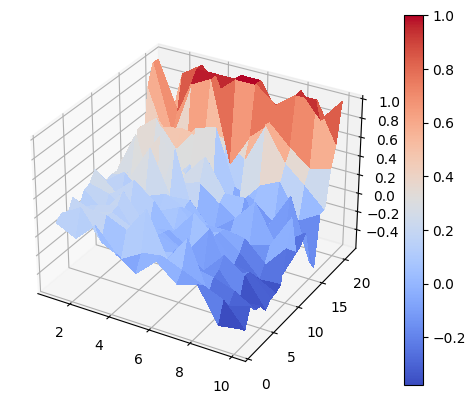

In [8]:
q_sarsa, _ = sarsa_estimate(10000, 100, 0.2, 1)
plot_q(q_sarsa)

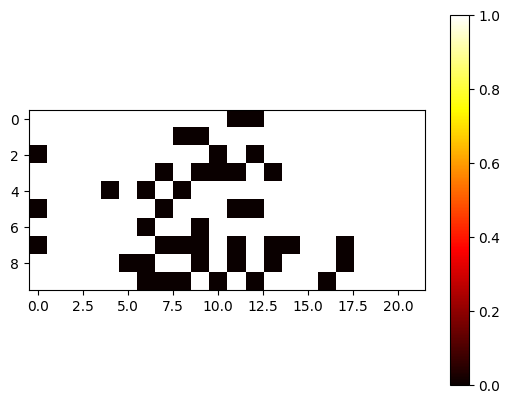

In [9]:
def policy_from_q_greedy(q):
    return np.argmax(q, axis=2)[1:, ...]

plt.imshow(policy_from_q_greedy(q_sarsa), cmap='hot')
plt.colorbar();

100%|██████████| 10000/10000 [00:01<00:00, 7089.88it/s]


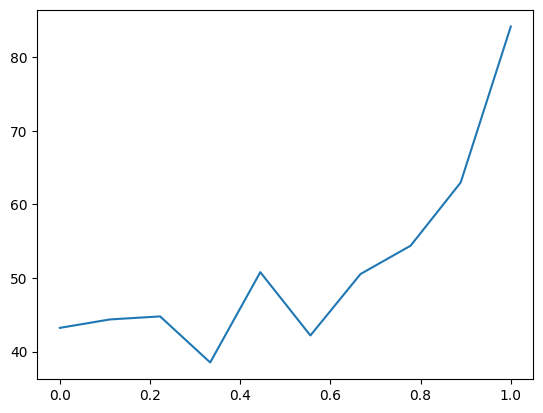

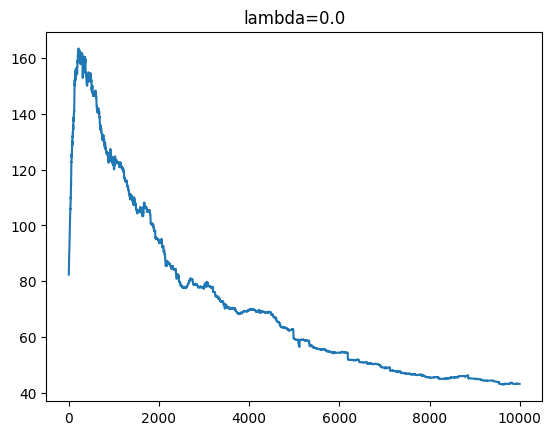

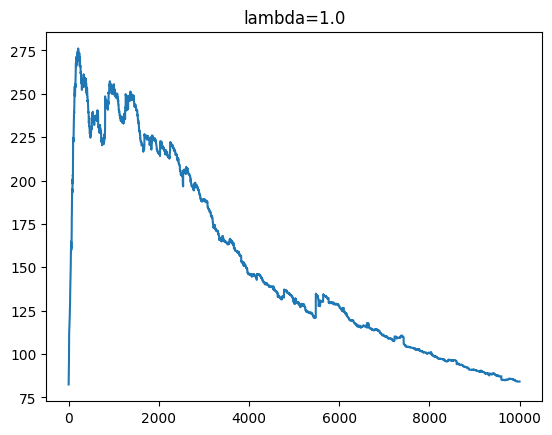

In [10]:
mse_vals = list()
lambdas = np.linspace(0, 1, 10)
mse_during_training_dict = dict()
episodes_count = 10000
for i, lambda_value in enumerate(lambdas):
    q_sarsa_local, mse_during_training = sarsa_estimate(
        episodes_count, 100, lambda_value, 1,
        mse_collect=np.isclose(lambda_value, 0) or np.isclose(lambda_value, 1),
        q_mc=q_mc
    )
    if mse_during_training:
        mse_during_training_dict[str(round(lambda_value, 1))] = mse_during_training
    mse = np.sum((q_sarsa_local - q_mc) ** 2)
    mse_vals.append(mse)
fig, ax = plt.subplots()
ax.plot(lambdas, mse_vals)
for k, v in mse_during_training_dict.items():
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, episodes_count), v)
    ax.set_title(f'lambda={k}')

# Подзадача 4

100%|██████████| 10000/10000 [00:07<00:00, 1329.19it/s]


[[-0.0357    ]
 [ 0.25618496]
 [-0.02796114]
 [-0.08164043]
 [ 0.20464624]
 [ 0.03607918]
 [ 0.06406059]
 [ 0.05868691]
 [ 0.04057138]
 [-0.36928268]
 [ 0.05200631]
 [ 0.71290177]
 [-0.0734708 ]
 [ 0.04378339]
 [-0.00151927]
 [-0.0416289 ]
 [-0.00786641]
 [ 0.01577929]
 [ 0.09860029]
 [-0.02927622]
 [-0.15265995]
 [-0.15316652]
 [ 0.03874258]
 [ 0.22372803]
 [-0.39481338]
 [-0.32836552]
 [ 0.00975127]
 [-0.05247829]
 [-0.18144146]
 [-0.16223634]
 [ 0.04392203]
 [-0.05929614]
 [-0.22948282]
 [-0.55616203]
 [-0.12876994]
 [ 0.48664877]]


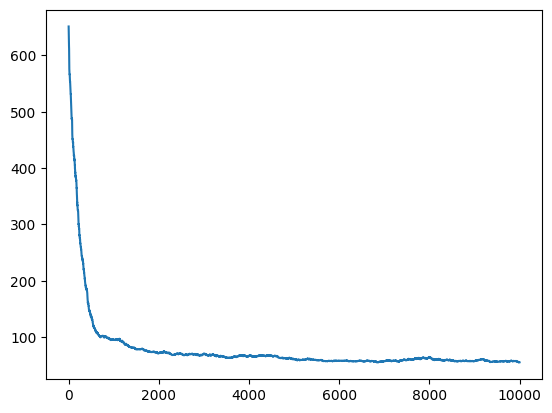

In [11]:
@cache # несколько противоречит смыслу задания, но не страшно ¯\_(ツ)_/¯
def to_features(s, a):
    if not hasattr(a, '__iter__'):
        s = np.array(s)
        a = np.array([a])
    taker_intervals = [[1,4], [4,7], [7,10]]
    player_intervals = [[0,6], [4,9], [7,12], [10,15], [13,18], [16,21]]
    taker_sum, player_sum = s
    out = list()

    for t1, t2 in taker_intervals:
        for p1, p2 in player_intervals:
            for a1 in (0, 1):
                if t1 <= taker_sum <= t2 and p1 <= player_sum <= p2 and a1 == a:
                    out.append(1)
                else:
                    out.append(0)

    return np.array(out).reshape((36, 1))


def weights_to_q(w):
    q = np.zeros((11, 22, 2))
    for s1 in range(11):
        for s2 in range(22):
            for a in range(2):
                q[s1, s2, a] = w.T.dot(to_features((s1, s2), a))
    return q


weights_to_q(np.zeros((36, 1)))


def epsilon_greedy(best_action, e):
    if np.random.random(1)[0] <= e:
        a = random.choice([0, 1])
    else:
        a = best_action
    return a


def sarsa_deep_estimate(episodes, lambda_coef, gamma, eps, alpha, mse_collect=False, q_mc=None):
    w = np.random.random((36, 1))

    def approx_q(s, a):
        return w.T.dot(to_features(s, a))

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }
    mse_vals = list()

    for _ in trange(episodes):
        e = np.zeros_like(w)
        s = get_start_state()
        a = epsilon_greedy(np.argmax([approx_q(s, i) for i in (0, 1)]), eps)

        while not is_terminal(s):
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )

            if not is_terminal(s1):
                a1 = epsilon_greedy(np.argmax([approx_q(s1, i) for i in (0, 1)]), eps)
                td_error = r + gamma * approx_q(s1, a1) - approx_q(s, a)
            else:
                a1 = None
                td_error = r - approx_q(s, a)

            e = gamma * lambda_coef * e + to_features(s, a)
            w_delta = alpha * td_error * e
            w += w_delta

            s = s1
            a = a1
        if mse_collect:
            q = weights_to_q(w)
            mse = np.sum((q - q_mc) ** 2)
            mse_vals.append(mse)
    return w, mse_vals

w, mse_during_training = sarsa_deep_estimate(
    episodes=10000,
    lambda_coef=0.4,
    gamma=1,
    eps=0.05,
    alpha=0.01,
    mse_collect=True,
    q_mc=q_mc
)
print(w)
plt.plot(np.arange(0, 10000), mse_during_training);

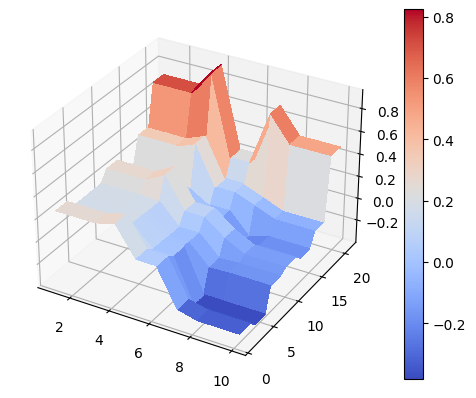

In [12]:
q_sarsa_deep = weights_to_q(w)
plot_q(q_sarsa_deep)

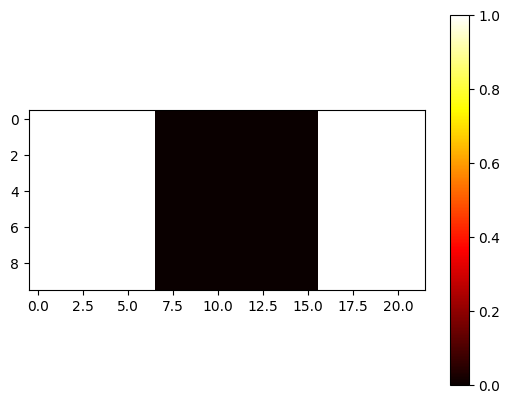

In [13]:
plt.imshow(policy_from_q_greedy(q_sarsa_deep), cmap='hot')
plt.colorbar();

100%|██████████| 10000/10000 [00:07<00:00, 1307.92it/s]


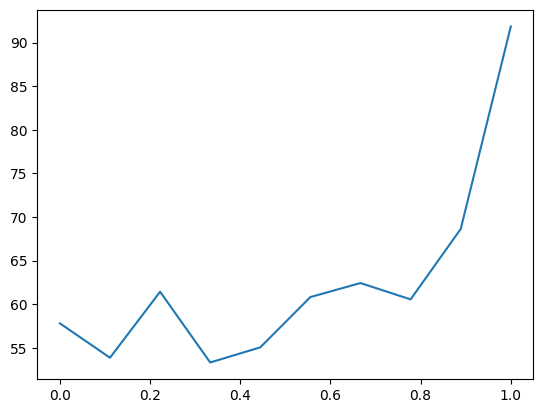

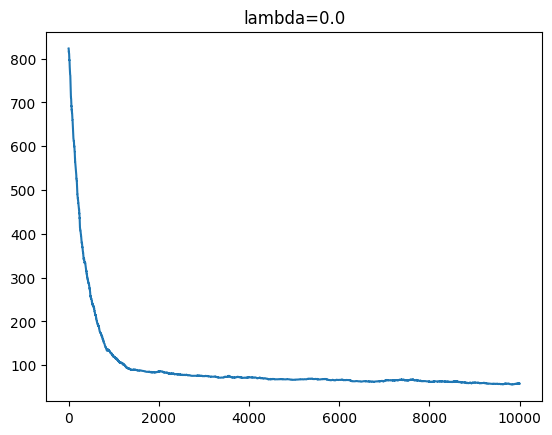

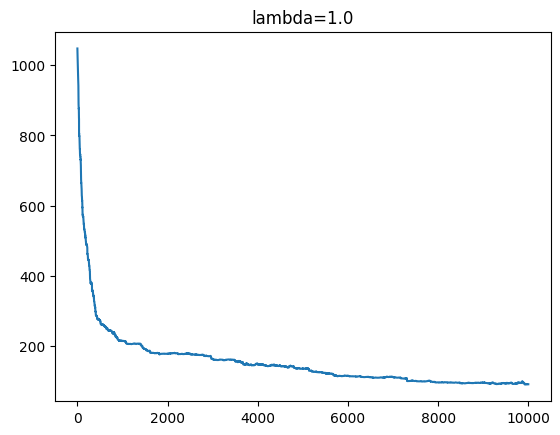

In [14]:
mse_vals = list()
lambdas = np.linspace(0, 1, 10)
mse_during_training_dict = dict()
episodes_count = 10000
for i, lambda_value in enumerate(lambdas):
    w_sarsa_local, mse_during_training = sarsa_deep_estimate(
        episodes=episodes_count,
        lambda_coef=lambda_value,
        gamma=1,
        eps=0.05,
        alpha=0.01,
        mse_collect=np.isclose(lambda_value, 0) or np.isclose(lambda_value, 1),
        q_mc=q_mc
    )
    if mse_during_training:
        mse_during_training_dict[str(round(lambda_value, 1))] = mse_during_training
    q_sarsa_local = weights_to_q(w_sarsa_local)
    mse = np.sum((q_sarsa_local - q_mc) ** 2)
    mse_vals.append(mse)
fig, ax = plt.subplots()
ax.plot(lambdas, mse_vals)
for k, v in mse_during_training_dict.items():
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, episodes_count), v)
    ax.set_title(f'lambda={k}')